<a href="https://colab.research.google.com/github/cooolbabu/GoogleGemini101/blob/main/Gemini01/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Anomaly detection with embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/examples/anomaly_detection"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Generative AI</a>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/examples/anomaly_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/examples/anomaly_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to use the embeddings from the Gemini API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html){:.external} and detect outliers outside a particular radius of the central point of each categorical cluster.

For more information on getting started with embeddings generated from the Gemini API, check out the [Python quickstart](../tutorials/python_quickstart.ipynb#use_embeddings).

## Prerequisites

You can run this quickstart in Google Colab.

To complete this quickstart on your own development environment, ensure that your envirmonement meets the following requirements:

-  Python 3.9+
-  An installation of `jupyter` to run the notebook.

## Setup

First, download and install the Gemini API Python library.

In [1]:
!pip install -U -q google.generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.9/146.9 kB 2.2 MB/s eta 0:00:00


In [2]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import google.generativeai as genai
import google.ai.generativelanguage as glm

# Used to securely store your API key
from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

### Grab an API Key

Before you can use the Gemini API, you must first obtain an API key. If you don't already have one, create a key with one click in Google AI Studio.

<a class="button button-primary" href="https://makersuite.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `API_KEY`.

Once you have the API key, pass it to the SDK. You can do this in two ways:

* Put the key in the `GOOGLE_API_KEY` environment variable (the SDK will automatically pick it up from there).
* Pass the key to `genai.configure(api_key=...)`

In [4]:
# Or use `os.getenv('API_KEY')` to fetch an environment variable.
API_KEY=userdata.get('Gemini_API_Key')

genai.configure(api_key=API_KEY)

Key Point: Next, you will choose a model. Any embedding model will work for this tutorial, but for real applications it's important to choose a specific model and stick with it. The outputs of different models are not compatible with each other.

**Note**: At this time, the Gemini API is [only available in certain regions](https://developers.generativeai.google/available_regions).

In [5]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001


## Prepare dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [6]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [8]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [9]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data]

In [10]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [11]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

,index,Text,Label,Class Name
0,1650,[EFF] Initial EFF Analysis of Clinton Privacy...,11,sci.crypt
1,1651,"Re: Pgp, PEM, and RFC's \nOrganization: Oce G...",11,sci.crypt
2,1652,Re: Fighting the Clipper Initiative\nOrganiza...,11,sci.crypt
3,1653,Re: Clipper Crypto\nOrganization: Stratus Com...,11,sci.crypt
4,1654,Re: Organized Lobbying for Cryptography\nRepl...,11,sci.crypt
...,...,...,...,...
595,2245,Subject: Re: Vandalizing the sky.\n\nOrganizat...,14,sci.space
596,2246,Re: Why not give $1 billion to first year-lon...,14,sci.space
597,2247,Re: Death and Taxes (was Why not give $1 bill...,14,sci.space
598,2248,Re: space news from Feb 1 AW&ST\nNntp-Posting...,14,sci.space


In [12]:
df_train['Class Name'].value_counts()

sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: Class Name, dtype: int64

## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the new embeddings model, embedding-001, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [13]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")['embedding']
    return np.array(embedding)

  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)
df_train.drop('index', axis=1, inplace=True)

  0%|          | 0/600 [00:00<?, ?it/s]

## Dimensionality reduction

The dimension of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [14]:
len(df_train['Embeddings'][0])

768

In [15]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [16]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [17]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,46.890923,-4.594273,sci.crypt
1,37.739368,6.221799,sci.crypt
2,42.262463,-9.706017,sci.crypt
3,44.115036,-5.087837,sci.crypt
4,33.380821,4.981379,sci.crypt
...,...,...,...
595,-10.669189,-32.508465,sci.space
596,-15.823459,-15.648663,sci.space
597,-15.428537,-12.004678,sci.space
598,-2.212181,-22.684107,sci.space


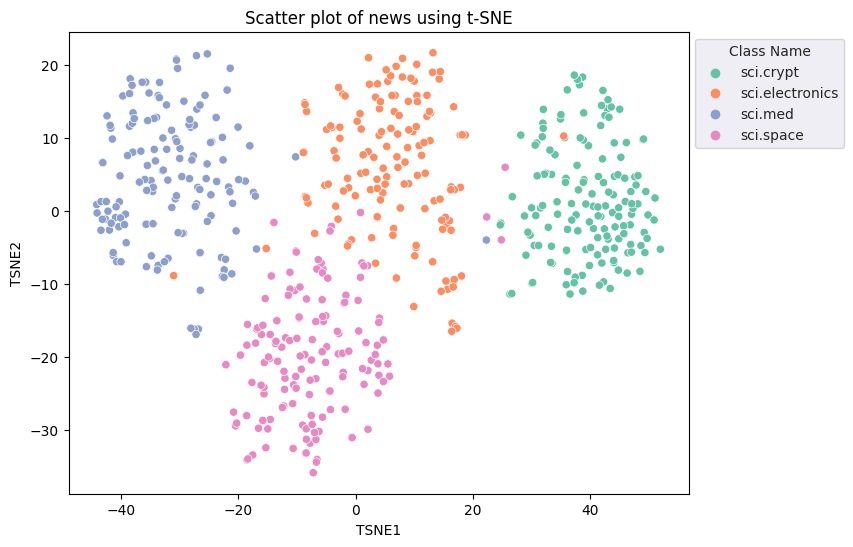

In [18]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [19]:
def get_centroids(df_tsne):
  # Get the centroid of each cluster
  centroids = df_tsne.groupby('Class Name').mean()
  return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,39.515255,1.272669
sci.electronics,6.232860,5.490641
sci.med,-31.191744,4.572878
sci.space,-7.571485,-19.591940


In [20]:
def get_embedding_centroids(df):
  emb_centroids = dict()
  grouped = df.groupby('Class Name')
  for c in grouped.groups:
    sub_df = grouped.get_group(c)
    # Get the centroid value of dimension 768
    emb_centroids[c] = np.mean(sub_df['Embeddings'], axis=0)

  return emb_centroids

In [21]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

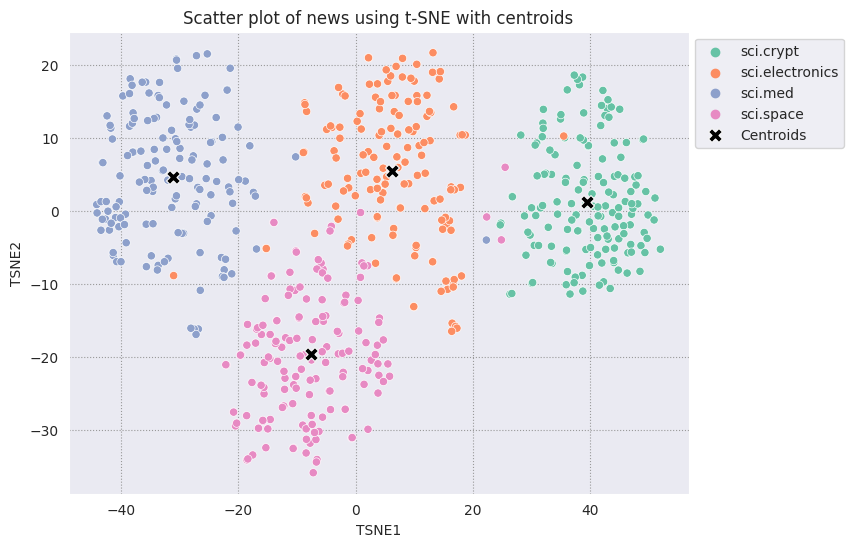

In [22]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [23]:
def calculate_euclidean_distance(p1, p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
  for idx, row in df.iterrows():
    class_name = row['Class Name'] # Get class name of row
    # Compare centroid distances
    dist = calculate_euclidean_distance(row['Embeddings'],
                                        emb_centroids[class_name])
    df.at[idx, 'Outlier'] = dist > radius

  return len(df[df['Outlier'] == True])

In [24]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_train, emb_c, i))

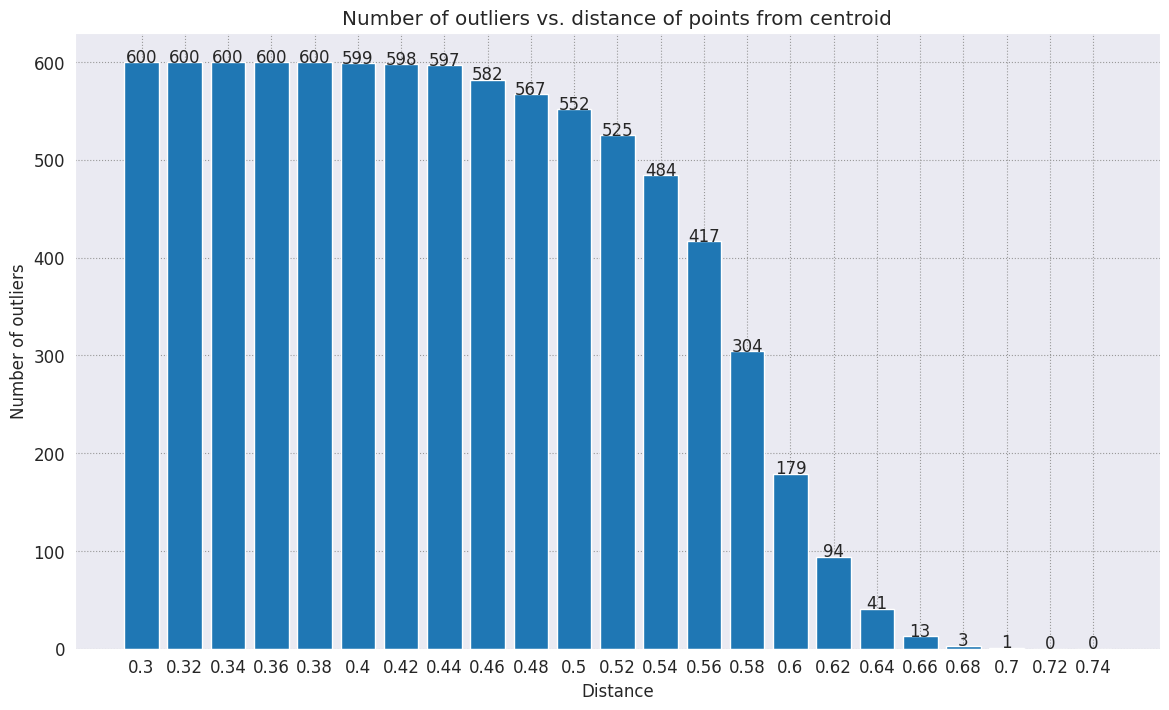

In [25]:
# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
  plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.62 is used, but you can change this value.

In [26]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train['Outlier'] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
5,Cryptography FAQ 03/10 - Basic Cryptology\nOrg...,11,sci.crypt,"[0.023759395, -0.035561457, -0.053390905, -0.0...",True
30,Cryptography FAQ 04/10 - Mathematical Cryptolo...,11,sci.crypt,"[0.0022418625, -0.061940957, -0.047118917, -0....",True
44,[Rubick] Shortest Path Algorithm - Status?\nO...,11,sci.crypt,"[0.031179903, -0.021885812, -0.05053699, -0.02...",True
56,Re: Trinomial-Based PRNG\nOrganization: Schoo...,11,sci.crypt,"[-0.008872381, -0.06083613, -0.0613925, -0.009...",True
66,Re: The source of that announcement\nOrganiza...,11,sci.crypt,"[0.0148236565, -0.023995584, -0.05186253, -0.0...",True


In [27]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]

Plot the outliers and denote them using a transparent red color.

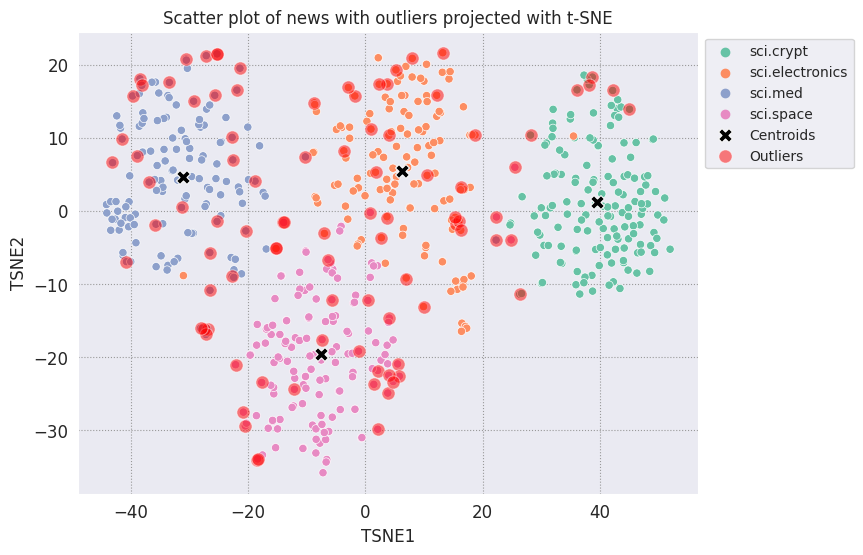

In [28]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [29]:
sci_crypt_outliers = df_outliers[df_outliers['Class Name'] == 'sci.crypt']
print(sci_crypt_outliers['Text'].iloc[0])

Cryptography FAQ 03/10 - Basic Cryptology
Organization: The Crypt Cabal
Lines: 187
Expires: 22 May 1993 04:00:07 GMT
Reply-To: 
NNTP-Posting-Host: pad-thai.aktis.com
Summary: Part 3 of 10 of the sci.crypt FAQ, Basic Cryptology.
 Definitions of basic terms. Beginner references. Cryptanalysis and
 theoretical/practical strength of ciphers.
X-Last-Updated: 1993/04/16

Archive-name: cryptography-faq/part03
Last-modified: 1993/4/15


FAQ for sci.crypt, part 3: Basic Cryptology

This is the third of ten parts of the sci.crypt FAQ. The parts are
mostly independent, but you should read the first part before the rest.
We don't have the time to send out missing parts by mail, so don't ask.
Notes such as ``[KAH67]'' refer to the reference list in the last part.

The sections of this FAQ are available via anonymous FTP to rtfm.mit.edu 
as /pub/usenet/news.answers/cryptography-faq/part[xx].  The Cryptography 
FAQ is posted to the newsgroups sci.crypt, sci.answers, and news.answers 
every 21 days.



In [30]:
sci_elec_outliers = df_outliers[df_outliers['Class Name'] == 'sci.electronics']
print(sci_elec_outliers['Text'].iloc[0])

 Re: A question about 120VAC outlet wiring..
Nntp-Posting-Host: techmac10.tech.mtu.edu
Organization: Michigan Technological University
Lines: 32

In article <>,
  wrote:
> 
> Hello
> I'm considering modernizing some old wiring in my home, and
> I need a little advice on outlet wiring.  Several outlets
> are the old 'two prong' type, without the ground.  Naturally,
> the wire feeding these outlets is 12/2, WITHOUT the ground
> wire.  I noticed at the fusebox that some circuits have the
> 12/2 with ground, and that on these circuits, the ground
> wire was tied to the same bus as the neutral  wire.
> 
> SO..  Here's my question.  It seems to me that I'd have the
> same electrical circuit if I hooked the neutral[D[D[D[D[D[D[D[D[D[D[Da jumper from the neutral
> over to the ground screw on new 'three prong' grounding outlets.
> What's wrong with my reasoning here?  

First, it will not pass a National Electrical code inspection.
Secondly, The neutral wire is current carrying and the ground w

In [31]:
sci_med_outliers = df_outliers[df_outliers['Class Name'] == 'sci.med']
print(sci_med_outliers['Text'].iloc[0])

 Foreskin Troubles
Organization: Virginia's Public Education Network 
Lines: 3

What can be done, short of circumcision, for an adult male
whose foreskin will not retract?




In [32]:
sci_space_outliers = df_outliers[df_outliers['Class Name'] == 'sci.space']
print(sci_space_outliers['Text'].iloc[0])

 Last call: S/W wizard position at Tandem 
Nntp-Posting-Host: 130.252.132.77
Organization: Tandem Computers Incorporated, Cupertino, CA
Lines: 28

Well, we got some responses and are doing some interviews with interesting
responders. However, just in case the other posting was overlooked by an
incredibly talented person ... Mea Culpa for posting this here for Mike,
but we're looking for someone special:

   Tandem Computers is currently looking for a software wizard to help
 us architect & implement a fault-tolerant generalized instrumentation
 subsystem as part of our proprietary operating system kernel . The TNS Kernel is a proprietary, loosely-coupled parallel,
 message-based operating system. The TNS Kernel has wide connectivity
 to open standards.
   In this key individual contributor role, you will work with other
 developers working on various components of the Transaction Management
 Facility.
   Your background needs to encompass some of the following 4 categories
 :
   Catego

## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that t-SNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis){:.external}.

To learn how to use other services in the Gemini API, visit the [Python quickstart](../tutorials/python_quickstart.ipynb).

To learn more about how you can use the embeddings, check out the [examples](../examples?keywords=embed) available. To learn how to create them from scratch, see TensorFlow's [Word Embeddings](https://www.tensorflow.org/text/guide/word_embeddings){:.external} tutorial.